In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import stats 


In [166]:
data = pd.read_csv('fake_job_postings.csv')

In [167]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<AxesSubplot:>

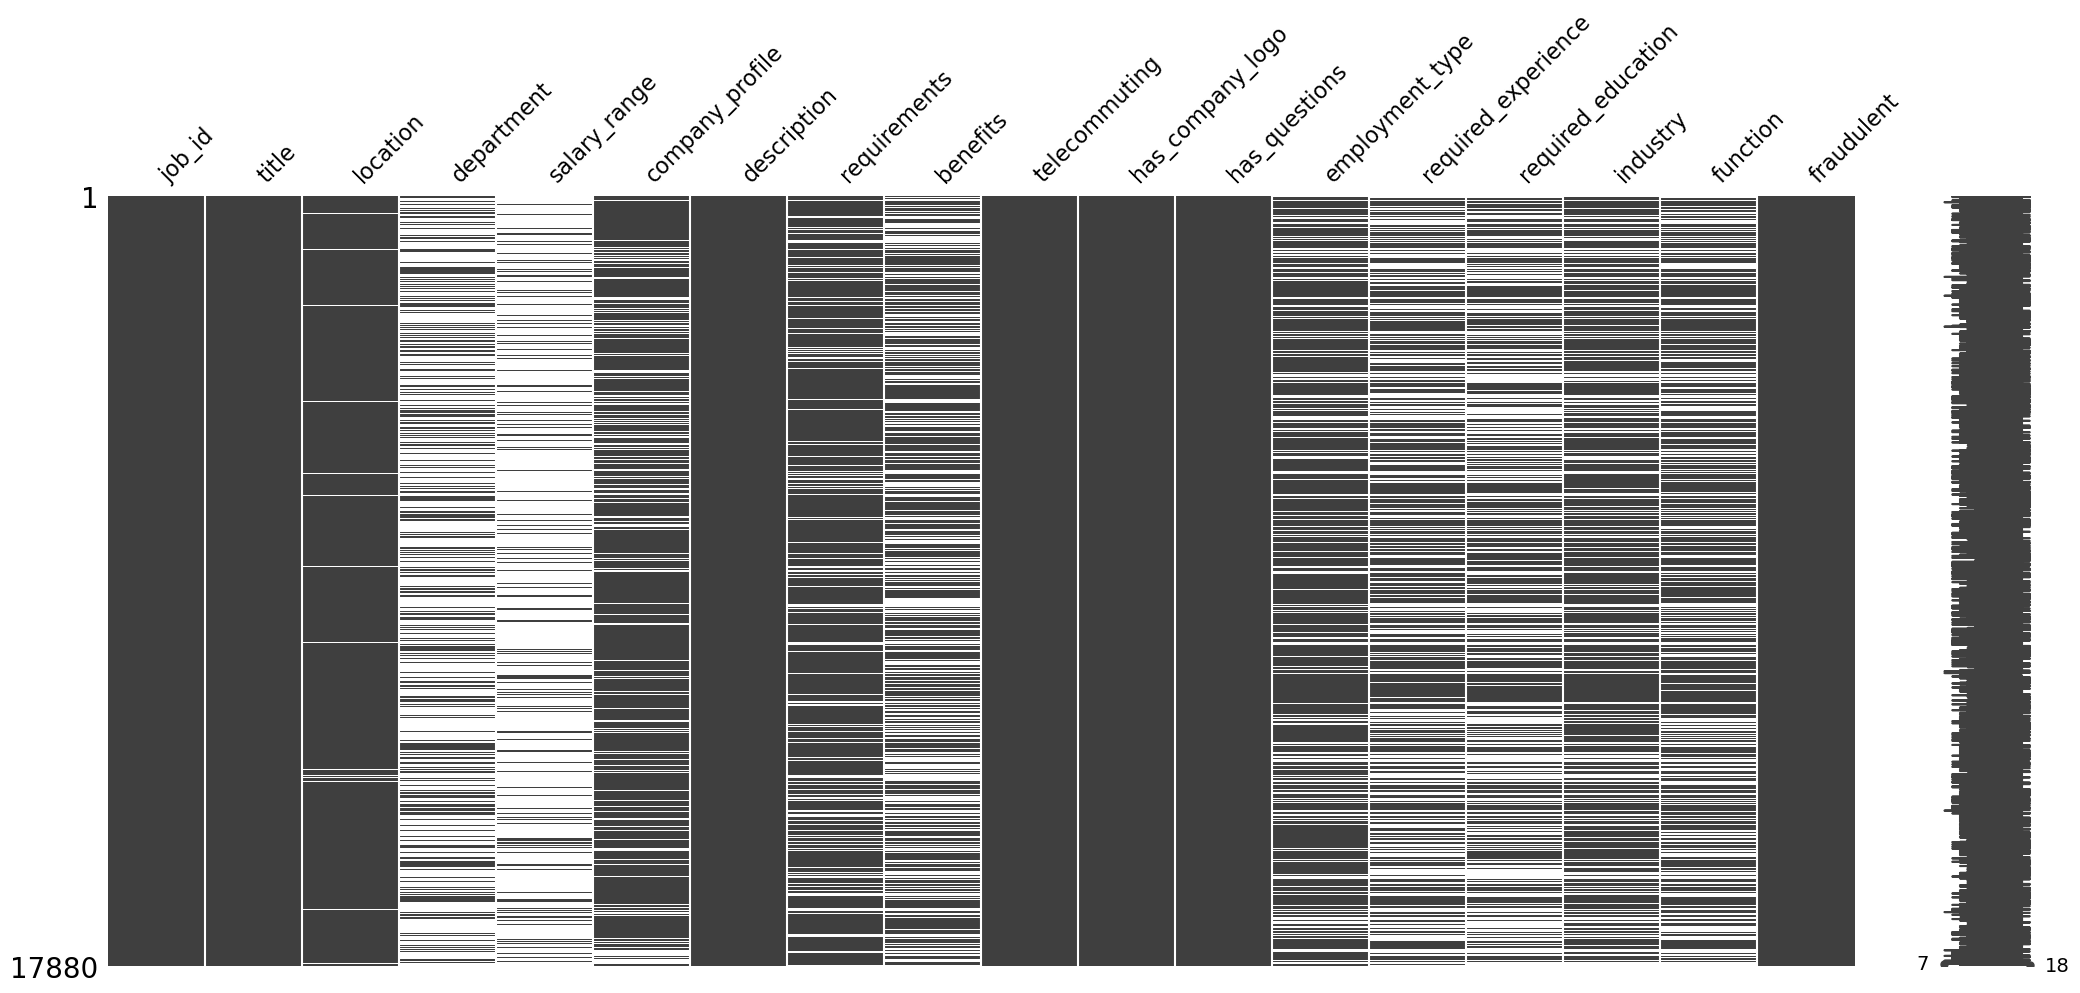

In [168]:
#check missing data in the dataset 
msno.matrix(data)

In [169]:
#check the number of missing data in each column as a definite value
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [170]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 0, 'Category')

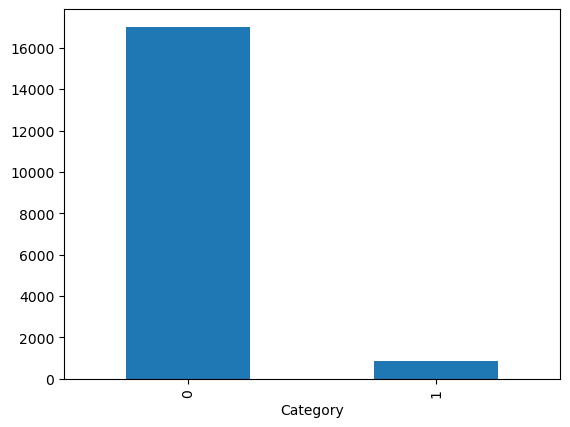

In [171]:
#count numbe of fraud and real job postings
value_counts = data['fraudulent'].value_counts()
plot = value_counts.plot(kind='bar')
plot.set_xlabel('Category')

#q: how to add labels to the bar chart?





Get length of discription based columns... Feature engineering

In [172]:
#feature enigneering
columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']

#replace missing values with space
for col in columns:
    data[col].fillna('')
    

#find length and wordcount of each column from the columns list
for col in columns:
   data[col+"_length"] = data[col].apply(lambda x: len(str(x)))
   data[col+"_word_count"] = data[col].apply(lambda x: len(str(x).split()))

In [173]:
#make a new column that combines all the text from the columns list
data['combined_text'] = data['title'] + ' ' + data['company_profile'] + ' ' + data['description'] + ' ' + data['requirements'] + ' ' + data['benefits']
data['combined_text'] = data['combined_text'].fillna('')

#tfidf

tfidf = TfidfVectorizer(max_features=500, norm='l2', stop_words='english')
tfidf.fit(data['combined_text'])
tfidf_matrix = tfidf.transform(data['combined_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

#concatenate tfidf_df with data
data = pd.concat([data, tfidf_df], axis=1)

ones hot encoding


In [174]:
#ones hot encoding
cat_cols = ["employment_type", "required_experience", "required_education", "industry", "function"]

for col in cat_cols:
    endcoded = pd.get_dummies(data[col])
    data = pd.concat([data, endcoded], axis=1)

In [175]:
#drop unnecessary columns
drop_cols = ['combined_text', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

for i in drop_cols:
    data.drop(i, axis=1, inplace=True)

In [176]:
data.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_length,title_word_count,company_profile_length,company_profile_word_count,description_length,...,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,1,0,1,0,0,16,2,885,141,905,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,41,6,1286,153,2077,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,39,4,879,141,355,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,33,5,614,85,2600,...,0,0,0,0,1,0,0,0,0,0
4,5,0,1,1,0,19,3,1628,207,1520,...,0,0,0,0,0,0,0,0,0,0


In [177]:
#set label
label = data['fraudulent']
data.drop('fraudulent', axis=1, inplace=True)

In [178]:
#standardize data
for col in data.columns:
    data[col] = stats.zscore(data[col])

Do random over sampling 


In [179]:
#oversampling
ros = RandomOverSampler(random_state=0)
data, label = ros.fit_resample(data, label)

In [180]:
corr = data.corr()


<AxesSubplot:>

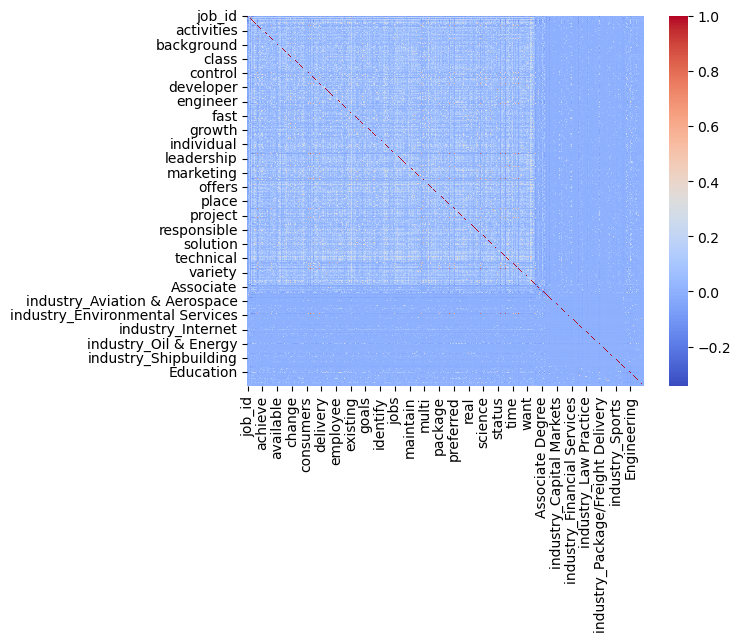

In [181]:
sns.heatmap(corr, annot=False, cmap='coolwarm')

In [182]:
#split data // can use train test validate split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=40)

In [183]:

#logistic regression

logreg =  LogisticRegression(solver='liblinear') 
logreg.fit(X_train,y_train) 
y_pred=logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9079243804486238


In [184]:
#confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

Text(0.5, 427.9555555555555, 'Predicted label')

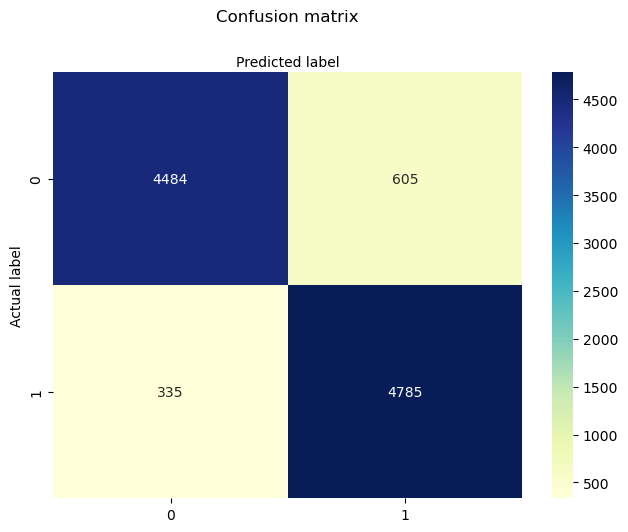

In [185]:
#visualize confusion matrix

class_names=[0,1]
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

Do SVC

In [186]:
#Create an SVC model
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9165442256832207


Do TF IDF

Text(0.5, 427.9555555555555, 'Predicted label')

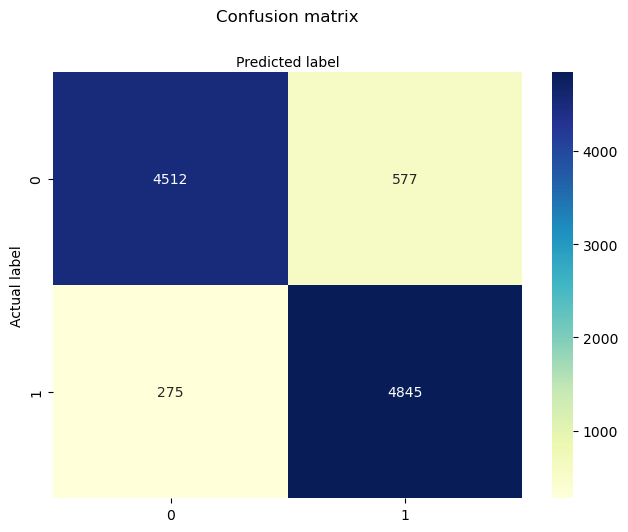

In [187]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

In [188]:
#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9990204721324322


Text(0.5, 427.9555555555555, 'Predicted label')

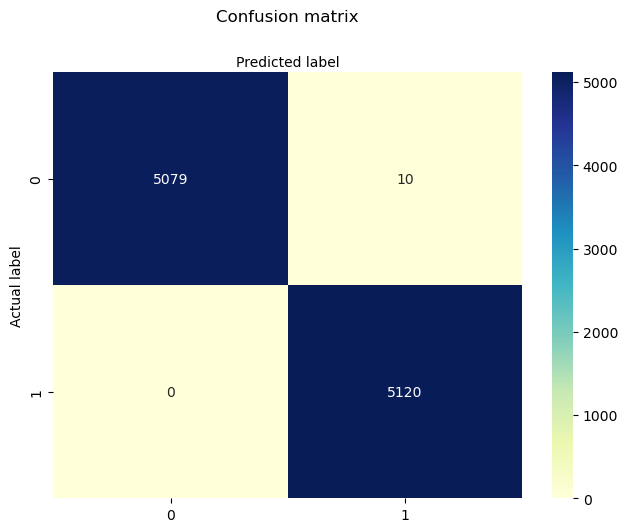

In [189]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

In [190]:
#count numbe of fraud and real job postings
value_counts = y_test.value_counts()
print(value_counts)


1    5120
0    5089
Name: fraudulent, dtype: int64
